# CS-577: Deep Learning. Homework 3

#### Student:             Jorge Gonzalez Lopez
#### CWID:                 A20474413
#### Semester:          Spring 2021

In [4]:
import numpy as np
import scipy.signal as sc
import cmath
import pickle
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers, regularizers
from keras.utils import to_categorical

import json
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold




%matplotlib inline

## Wine dataset (Regression)

In [5]:
# Load Regression dataset

In [6]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=';')

In [7]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [8]:
# Vectorize dataset, normalize inputs and split int train/val/test sets

In [9]:
y = np.array(data['quality'])
X = np.array(data)[:,:11]

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

X, Y = shuffle(X, y, random_state=2021)

# Split train/val
n_train = int(0.7*X.shape[0])

n_val = n_train + int(0.15*X.shape[0])

X_train = X[:n_train]
Y_train = Y[:n_train]

X_val = X[n_train:n_val]
Y_val = Y[n_train: n_val]

X_test = X[n_val:]
Y_test = Y[n_val:]

In [10]:
## Regression:

loss = ["mean_absolute_error", "mean_squared_error", "huber_loss", "log_cosh"]

opt = [
    [optimizers.SGD(learning_rate=1e-3, momentum=0.0, nesterov=False), 'SGD'],
    [optimizers.RMSprop(learning_rate=1e-3,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False), 'RMSprop'],
    [optimizers.Adagrad(learning_rate=1e-3,initial_accumulator_value=0.1,epsilon=1e-07), 'Adagrad'],
    [optimizers.Adam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999,epsilon=1e-07), 'Adam'],
    [optimizers.Adadelta(learning_rate=1e-2, rho=0.95, epsilon=1e-07), 'Adadelta'],
    [optimizers.Adamax(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 'Adamax'],
    [optimizers.Nadam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 'Nadam']
    ]

reg = [
    [regularizers.l1(0.01) ,'L1'],
    [regularizers.l2(0.01),'L2'],
    [layers.Dropout(0.25),'Dropout'],
    [layers.BatchNormalization(),'Batch Normalization'],
    [[3],'ensemble']]

In [11]:
def create_model(r = 0):
    if r == 0:
        model = keras.models.Sequential()
        model.add(keras.Input(shape=(X.shape[1],)))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(keras.layers.Dense(1))
    
    elif r == 1 or r == 2: #L1 or L2
        model = keras.models.Sequential()
        model.add(keras.Input(shape=(X.shape[1],)))
        model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer = reg[r-1][0]))
        model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer = reg[r-1][0]))
        model.add(keras.layers.Dense(128, activation='relu',kernel_regularizer = reg[r-1][0]))
        model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer = reg[r-1][0]))
        model.add(keras.layers.Dense(1))
    
    elif r == 3: #Dropout
        model = keras.models.Sequential()
        model.add(keras.Input(shape=(X.shape[1],)))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(reg[r-1][0])
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(reg[r-1][0])
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(reg[r-1][0])
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(reg[r-1][0])
        model.add(keras.layers.Dense(1))
        
    elif r == 4: #Batch Normalization
        model = keras.models.Sequential()
        model.add(keras.Input(shape=(X.shape[1],)))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(keras.layers.Dense(1))
        
    else:
        model = []
        for i in [1,2,4]:
            model.append(create_model(i))
    
    #model.summary()
    
    return model


In [12]:
# For each loss function: create a model and train it, keeping
# all hyper-parameters constant.

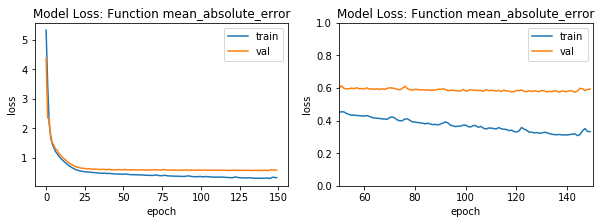

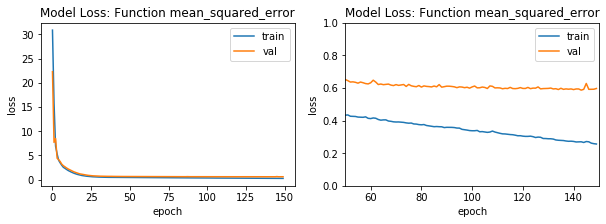

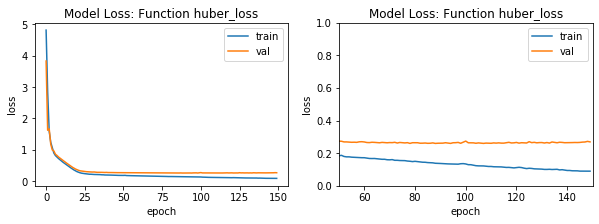

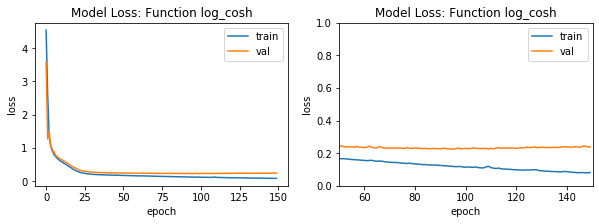

In [13]:
for l in loss:
    
    model = create_model()

    opt_fix = optimizers.Adam(learning_rate=1e-3)

    model.compile(optimizer = opt_fix, loss = l)
    
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 150, batch_size = 512, verbose = 0)
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss: Function '+ l)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss: Function '+ l)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.axis([50,150, 0, 1])

    plt.show()

In [14]:
best_loss = "log_cosh"

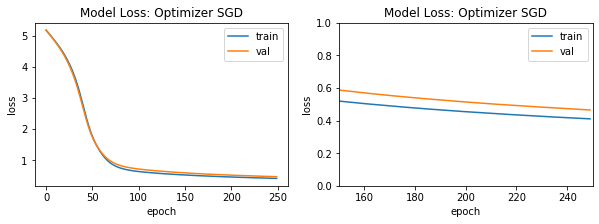

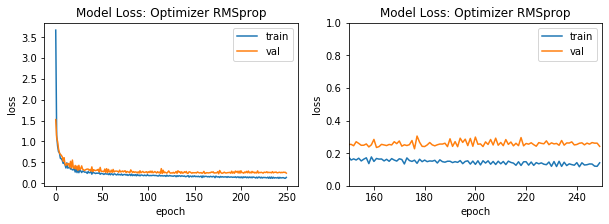

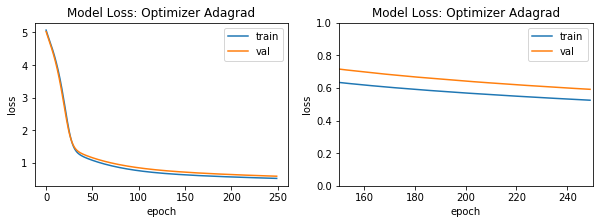

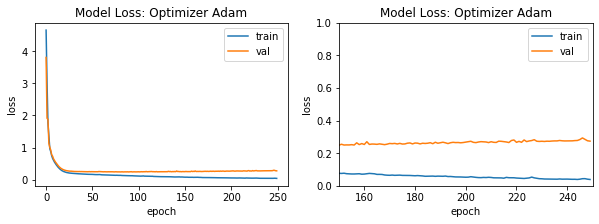

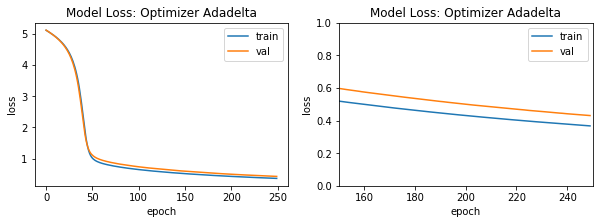

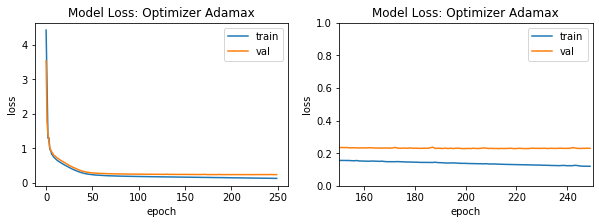

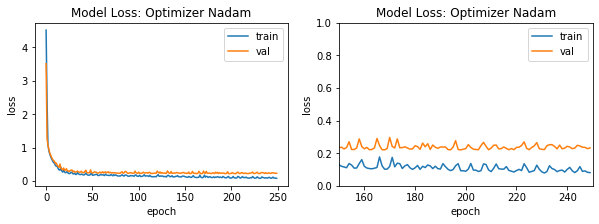

In [15]:
for o in opt:
    
    model = create_model()

    model.compile(optimizer = o[0], loss = best_loss)
    
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 250, batch_size = 512, verbose = 0)
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss: Optimizer '+ o[1])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss: Optimizer '+ o[1])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.axis([150,250, 0, 1])

    plt.show()

In [16]:
best_opt = opt[3][0] # Adam optimizer

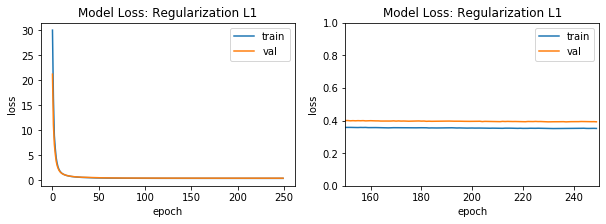

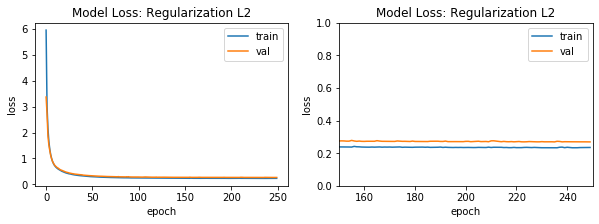

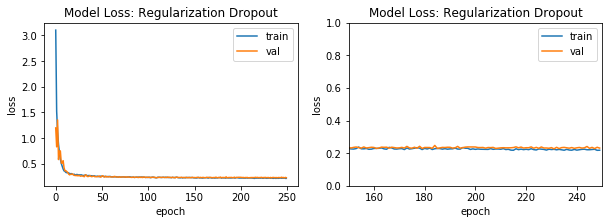

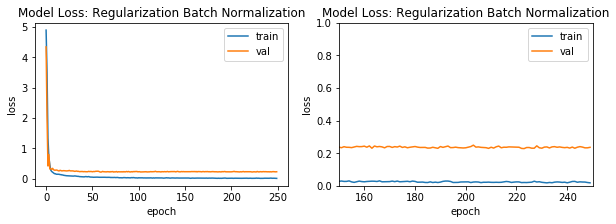

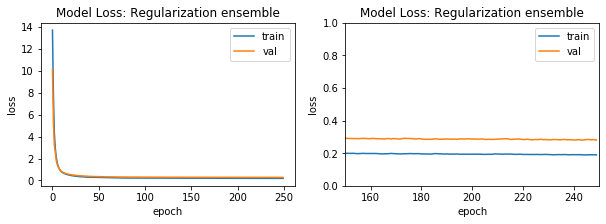

In [19]:
for i in range(1,len(reg)+1): #From 1 to 5
    
    model = create_model(i)
    
    if i == 5:
        history_loss = []
        history_valloss = []
        for mod in model:
            mod.compile(optimizer = best_opt, loss = best_loss)
            hist = mod.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 250, batch_size = 512, verbose = 0)
            history_loss.append(hist.history['loss'])
            history_valloss.append(hist.history['val_loss'])
        
        plt.figure(figsize=(10, 3))
        plt.subplot(1,2,1)
        plt.plot(np.mean(history_loss,axis=0))
        plt.plot(np.mean(history_valloss,axis=0))
        plt.title('Model Loss: Regularization '+ reg[i-1][1])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])

        plt.subplot(1,2,2)
        plt.plot(np.mean(history_loss,axis=0))
        plt.plot(np.mean(history_valloss,axis=0))
        plt.title('Model Loss: Regularization '+ reg[i-1][1])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])
        plt.axis([150,250, 0, 1])
        
    else:
        model.compile(optimizer = best_opt, loss = best_loss)
    
        history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 250, batch_size = 512, verbose = 0)
    
        plt.figure(figsize=(10, 3))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss: Regularization '+ reg[i-1][1])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss: Regularization '+ reg[i-1][1])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])
        plt.axis([150,250, 0, 1])

    plt.show()

In [20]:
best_reg = 3 #Dropout

In [21]:
Train = False

model = create_model(best_reg)
model.compile(optimizer = best_opt, loss = best_loss)


if Train:
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 250, batch_size = 512, verbose = 0)

    model.save('model_reg.h5')

else:
    model.load_weights('model_reg.h5')



#new_model = keras.models.load_model('model_reg.h5')

In [22]:
model.evaluate(X_test, Y_test)

23/23 [==============================] - 0s 1ms/step - loss: 0.1895


0.1894679069519043

## Semeion dataset (Classification)

In [23]:
#Load classification dataset

In [24]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.data', delimiter=' ', header = None)

In [25]:
data = data.drop(columns =[266], axis = 0)

In [26]:
X = data[range(256)]
Y = data[range(256, 266)]

In [27]:
X, Y = shuffle(X, Y, random_state=2021)

# Split train/val
n_train = int(0.7*X.shape[0])

n_val = n_train + int(0.15*X.shape[0])

X_train = X[:n_train]
Y_train = Y[:n_train]

X_val = X[n_train:n_val]
Y_val = Y[n_train: n_val]

X_test = X[n_val:]
Y_test = Y[n_val:]

In [28]:
## Regression:

loss = ['categorical_crossentropy', 'kullback_leibler_divergence', 'hinge', 'squared_hinge']

opt = [
    [optimizers.SGD(learning_rate=1e-1, momentum=0.0, nesterov=False), 'SGD'],
    [optimizers.RMSprop(learning_rate=1e-3,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False), 'RMSprop'],
    [optimizers.Adagrad(learning_rate=1e-1,initial_accumulator_value=0.1,epsilon=1e-07), 'Adagrad'],
    [optimizers.Adam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999,epsilon=1e-07), 'Adam'],
    [optimizers.Adadelta(learning_rate=5e-1, rho=0.95, epsilon=1e-07), 'Adadelta'],
    [optimizers.Adamax(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 'Adamax'],
    [optimizers.Nadam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 'Nadam']
    ]

reg = [
    [regularizers.l1(0.01) ,'L1'],
    [regularizers.l2(0.01),'L2'],
    [layers.Dropout(0.25),'Dropout'],
    [layers.BatchNormalization(),'Batch Normalization'],
    [[3],'ensemble']]

In [29]:
def create_model(r = 0):
    if r == 0:
        model = keras.models.Sequential()
        model.add(keras.Input(shape=(X.shape[1],)))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(keras.layers.Dense(10, activation='softmax'))
    
    elif r == 1 or r == 2: #L1 or L2
        model = keras.models.Sequential()
        model.add(keras.Input(shape=(X.shape[1],)))
        model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer = reg[r-1][0]))
        model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer = reg[r-1][0]))
        model.add(keras.layers.Dense(128, activation='relu',kernel_regularizer = reg[r-1][0]))
        model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer = reg[r-1][0]))
        model.add(keras.layers.Dense(10, activation='softmax'))
    
    elif r == 3: #Dropout
        model = keras.models.Sequential()
        model.add(keras.Input(shape=(X.shape[1],)))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(reg[r-1][0])
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(reg[r-1][0])
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(reg[r-1][0])
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(reg[r-1][0])
        model.add(keras.layers.Dense(10, activation='softmax'))
        
    elif r == 4: #Batch Normalization
        model = keras.models.Sequential()
        model.add(keras.Input(shape=(X.shape[1],)))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(keras.layers.Dense(10, activation='softmax'))
        
    else:
        model = []
        for i in [1,2,4]:
            model.append(create_model(i))
    
    #model.summary()
    
    return model


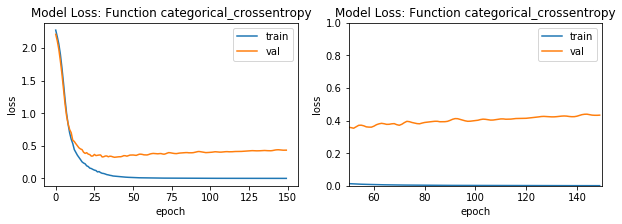

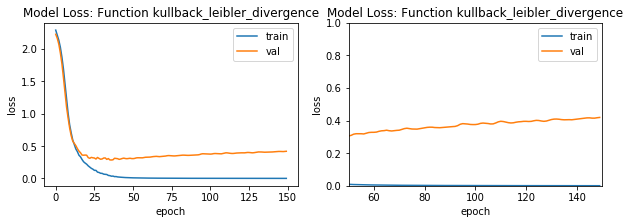

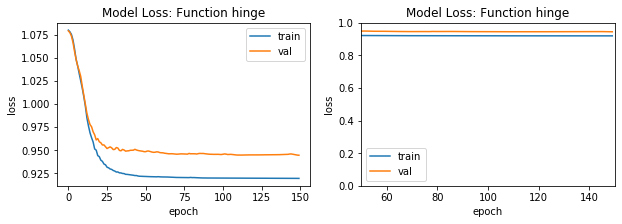

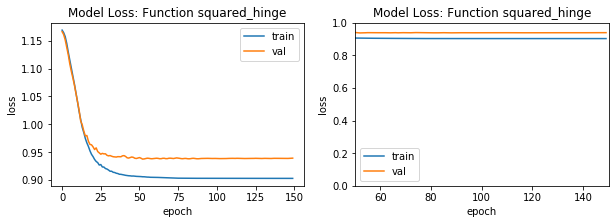

In [30]:
for l in loss:
    
    model = create_model()

    opt_fix = optimizers.Adam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999,epsilon=1e-07)

    model.compile(optimizer = opt_fix, loss = l)
    
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 150, batch_size = 512, verbose = 0)
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss: Function '+ l)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss: Function '+ l)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.axis([50,150, 0, 1])

    plt.show()

In [31]:
best_loss = 'kullback_leibler_divergence'

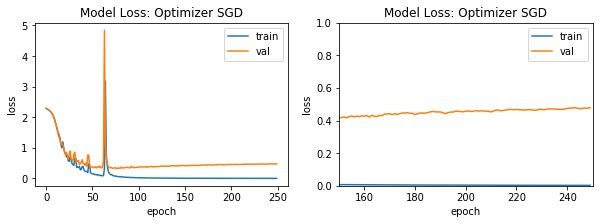

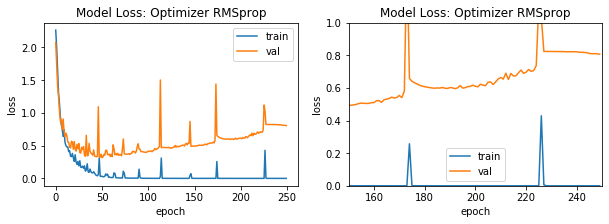

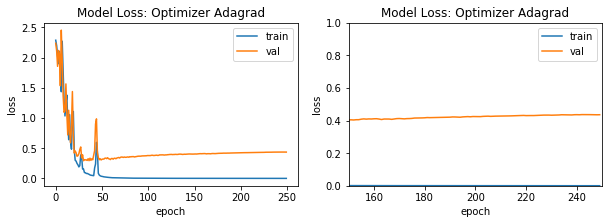

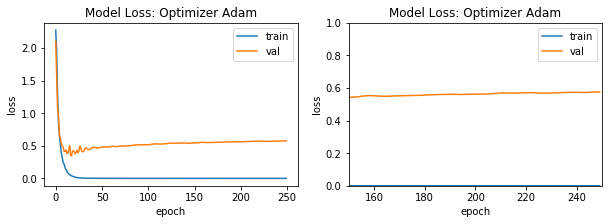

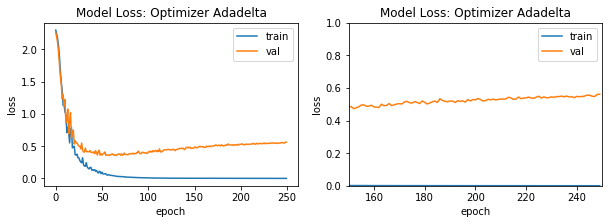

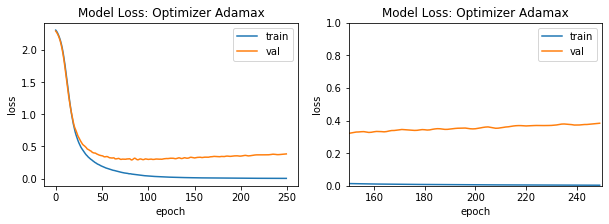

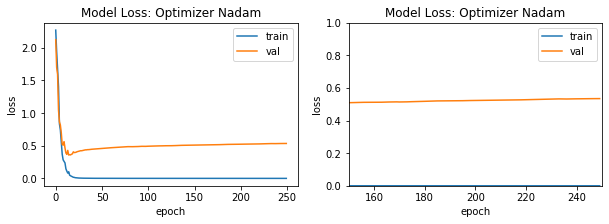

In [33]:
for o in opt:
    
    model = create_model()

    model.compile(optimizer = o[0], loss = best_loss)
    
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 250, batch_size = 512, verbose = 0)
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss: Optimizer '+ o[1])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss: Optimizer '+ o[1])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.axis([150,250, 0, 1])

    plt.show()

In [34]:
best_opt = opt[5][0] # Adamax optimizer

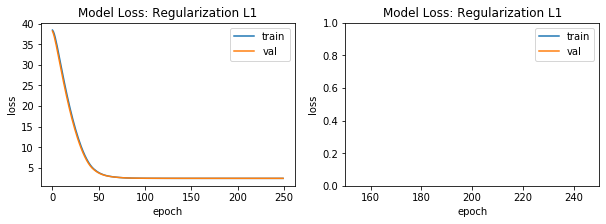

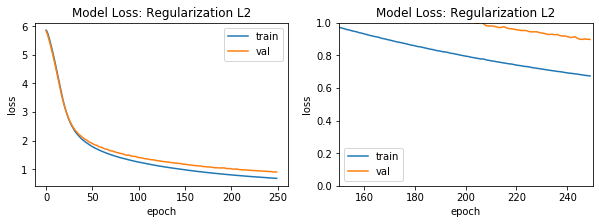

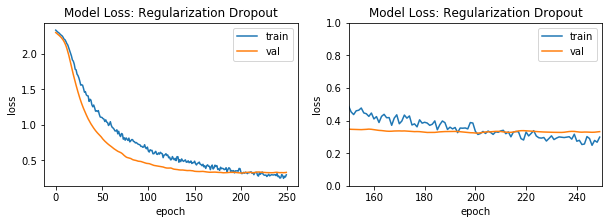

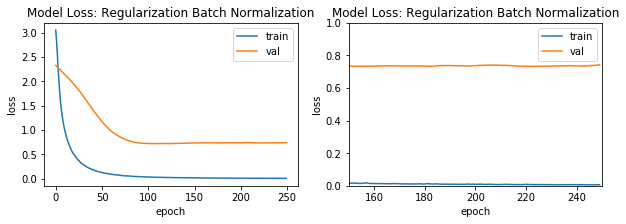

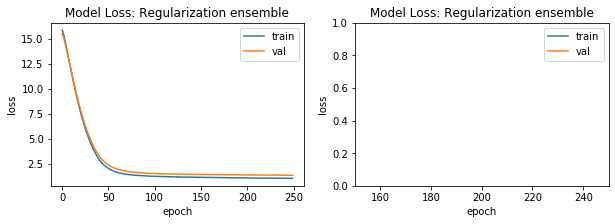

In [35]:
for i in range(1,len(reg)+1): #From 1 to 5
    
    model = create_model(i)
    
    if i == 5:
        history_loss = []
        history_valloss = []
        for mod in model:
            mod.compile(optimizer = best_opt, loss = best_loss)
            hist = mod.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 250, batch_size = 512, verbose = 0)
            history_loss.append(hist.history['loss'])
            history_valloss.append(hist.history['val_loss'])
        
        plt.figure(figsize=(10, 3))
        plt.subplot(1,2,1)
        plt.plot(np.mean(history_loss,axis=0))
        plt.plot(np.mean(history_valloss,axis=0))
        plt.title('Model Loss: Regularization '+ reg[i-1][1])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])

        plt.subplot(1,2,2)
        plt.plot(np.mean(history_loss,axis=0))
        plt.plot(np.mean(history_valloss,axis=0))
        plt.title('Model Loss: Regularization '+ reg[i-1][1])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])
        plt.axis([150,250, 0, 1])
        
    else:
        model.compile(optimizer = best_opt, loss = best_loss)
    
        history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 250, batch_size = 512, verbose = 0)
    
        plt.figure(figsize=(10, 3))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss: Regularization '+ reg[i-1][1])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss: Regularization '+ reg[i-1][1])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])
        plt.axis([150,250, 0, 1])

    plt.show()

In [36]:
best_reg = 3 #Dropout

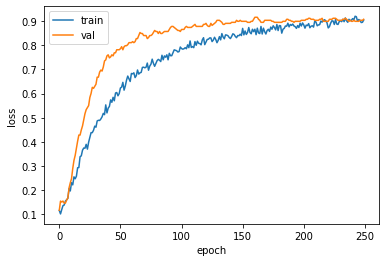

In [37]:
Train = False

model = create_model(best_reg)
model.compile(optimizer = best_opt, loss = best_loss, metrics = ['accuracy'])


if Train:
    hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 250, batch_size = 512, verbose = 0)

    
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
   
    model.save('model_clas.h5')

else:
    model.load_weights('model_clas.h5')



#new_model = keras.models.load_model('model_reg.h5')

In [38]:
model.evaluate(X_test, Y_test)

8/8 [==============================] - 0s 996us/step - loss: 0.3519 - accuracy: 0.8875


[0.3518523573875427, 0.887499988079071]